# Data Preprocessing

In [2]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the Free Energy of Solvation dataset
dataset = MoleculeNet(root=".", name="FreeSolv")

In [3]:
data = dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  485
Dataset length:  <bound method InMemoryDataset.len of FreeSolv(642)>
Dataset sample:  Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])
Sample  nodes:  13
Sample  edges:  26


C:\Users\NajibS\AppData\Roaming\Python\Python311\site-packages\torch_geometric\data\dataset.py:172: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


In [4]:
# Investiagte the features of the node of graph 
data[0].x

# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

# See the target value of data[0]
data[0].y

tensor([[-11.0100]])

In [5]:
data[0]["smiles"]


'CN(C)C(=O)c1ccc(cc1)OC'

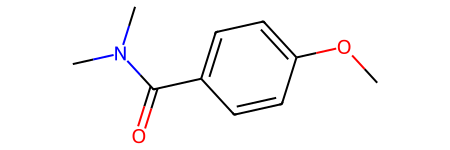

In [6]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

# Model definition

In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 10

class GCN(torch.nn.Module):
    def __init__(self, feature_count, hidden_dim, out_channels):
        # Init parent
        super(GCN, self).__init__()
        # GCN layers
        self.initial_conv = GCNConv(feature_count, hidden_dim,add_self_loops=True)
        self.conv1 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, add_self_loops=True)

        # Output layer
        self.linear = Linear(hidden_dim*2, out_channels)

    def forward(self, data):

        x, edge_index, batch_index = data.x, data.edge_index, data.batch
        x = x.float()

        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        #print(hidden.shape)
          
        # Global Pooling (stack different aggregations)
        embedding = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # returned hidden is [num_graphs, hidden_dim]
        #print(hidden.shape)

        # Apply a final (linear) classifier.
        x = self.linear(embedding)
        #print(x.shape)

        return x

model = GCN(data.num_features, 5,1)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 5)
  (conv1): GCNConv(5, 5)
  (conv2): GCNConv(5, 5)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)
Number of parameters:  121


# Training

In [8]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)  
batch_size = 32
pretrained = True
model_path = "GraphModel_pretrained.pth"
if pretrained:
   model.load_state_dict(torch.load(model_path))



# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)

loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=batch_size, shuffle=True, drop_last = True)

def train():
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      model.train()
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch) 
      # Calculating the loss and gradients
      #print(pred.shape)
      #print(batch.y.shape)
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

print("Starting training...")
losses = []
for epoch in range(2000):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.34198260307312
Epoch 100 | Train Loss 3.914827346801758
Epoch 200 | Train Loss 1.5845997333526611
Epoch 300 | Train Loss 3.0594546794891357
Epoch 400 | Train Loss 2.7028565406799316
Epoch 500 | Train Loss 2.6326541900634766
Epoch 600 | Train Loss 3.9533309936523438
Epoch 700 | Train Loss 1.6819130182266235
Epoch 800 | Train Loss 2.798470973968506
Epoch 900 | Train Loss 3.5149319171905518
Epoch 1000 | Train Loss 1.9054443836212158
Epoch 1100 | Train Loss 1.4019010066986084
Epoch 1200 | Train Loss 3.4268345832824707
Epoch 1300 | Train Loss 2.6569912433624268
Epoch 1400 | Train Loss 3.4268457889556885
Epoch 1500 | Train Loss 2.304778575897217
Epoch 1600 | Train Loss 1.392305612564087
Epoch 1700 | Train Loss 2.2099459171295166
Epoch 1800 | Train Loss 1.970443844795227
Epoch 1900 | Train Loss 4.245005130767822


In [31]:
model_path = "GraphModel_pretrained.pth"
torch.save(model.state_dict(), model_path)

In [9]:
# Visualize learning (training loss)
import plotly.graph_objects as go
from plotly.offline import iplot


losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 

trace = go.Scatter(x = loss_indices, y = losses_float, mode = "lines")

layout = go.Layout(title = "losses during training", xaxis=dict(title = "epoch"),
                   yaxis = dict(title = "loss"))

figure = go.Figure(data = [trace], layout=layout)

iplot(figure)

In [17]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred = model(test_batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])


In [18]:
trace = go.Scatter(x = df["y_real"],y = df["y_pred"], mode = "markers")
line_trace = go.Scatter(x = [min(df["y_real"]), max(df["y_real"])],
                        y = [min(df["y_real"]), max(df["y_real"])],
                        mode = "lines",
                        marker=dict(color='blue'),
                        name='Perfect Prediction')
layout = go.Layout(title = "predicted values vs real values", xaxis=dict(title = "epoch"),
                   yaxis = dict(title = "loss"))

figure = go.Figure(data = [trace, line_trace], layout=layout)

iplot(figure)